In [60]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas import concat
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [61]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [62]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [63]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [64]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [65]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [66]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [67]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [68]:
df_train.tail(10)

,week,wPreis,Plz,full,date
date,,,,,
2023-05-22,2023-21,27.487014,"['25', '24']",A1 & A2 - geschreddert,2023-05-22
2023-05-29,2023-22,34.472538,"['25', '24']",A1 & A2 - geschreddert,2023-05-29
2023-06-05,2023-23,34.003188,"['25', '24']",A1 & A2 - geschreddert,2023-06-05
2023-06-12,2023-24,27.248645,"['25', '24']",A1 & A2 - geschreddert,2023-06-12
2023-06-19,2023-25,25.673098,"['25', '24']",A1 & A2 - geschreddert,2023-06-19
2023-06-26,2023-26,22.501691,"['25', '24']",A1 & A2 - geschreddert,2023-06-26
2023-07-03,2023-27,18.514178,"['25', '24']",A1 & A2 - geschreddert,2023-07-03
2023-07-10,2023-28,28.985554,"['25', '24']",A1 & A2 - geschreddert,2023-07-10
2023-07-17,2023-29,16.847234,"['25', '24']",A1 & A2 - geschreddert,2023-07-17


In [69]:
df_test

,week,wPreis,Plz,full,date
date,,,,,
2023-07-31,2023-31,7.458214,"['25', '24']",A1 & A2 - geschreddert,2023-07-31
2023-08-07,2023-32,7.832750,"['25', '24']",A1 & A2 - geschreddert,2023-08-07
2023-08-14,2023-33,3.525113,"['25', '24']",A1 & A2 - geschreddert,2023-08-14
2023-08-21,2023-34,3.896402,"['25', '24']",A1 & A2 - geschreddert,2023-08-21
2023-08-28,2023-35,6.754483,"['25', '24']",A1 & A2 - geschreddert,2023-08-28
2023-09-04,2023-36,2.053265,"['25', '24']",A1 & A2 - geschreddert,2023-09-04


# XGBOOST

In [70]:
from xgboost import XGBRegressor


In [71]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [72]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [73]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy,verbose = True)
 # make a one-step prediction
 yhat = model.predict(asarray([testX]))
 return yhat[0]

## Walk-forward validation using XGBoost

Retraining model on updated training data, appended at every step to add the new value from test set.

In [74]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = xgboost_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)

    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy

In [75]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [76]:
# transform the time series data into supervised learning
xgb_data = series_to_supervised(X, n_in=4)

In [77]:
from sklearn.metrics import mean_squared_error


>expected=7.5, predicted=15.1
>expected=7.8, predicted=9.0
>expected=3.5, predicted=6.0
>expected=3.9, predicted=6.1
>expected=6.8, predicted=7.1


>expected=2.1, predicted=4.7
XGBoost Walk-forward Forecast Accuracy: 2.751
MAE: 2.751
ME: 2.751
RMSE: 3.603
Direction Accuracy: 0.800


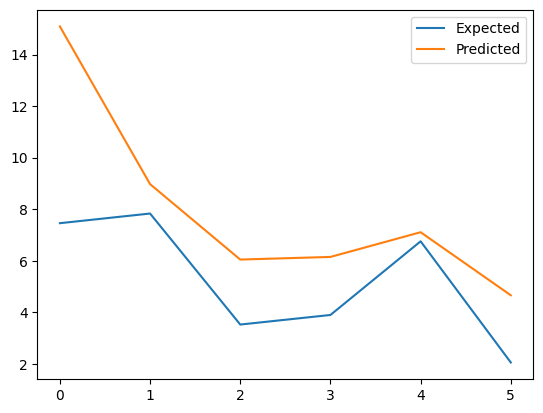

In [78]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = walk_forward_validation(data2, 6)
print('XGBoost Walk-forward Forecast Accuracy: %.3f' % mae)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

The metrics are poorer than Static ARIMA but direction accuracy is similar.

## Rolling forecast with XGBoost  

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [79]:
train, test = train_test_split(xgb_data, 6)
train = asarray(train)
trainX, trainy = train[:, :-1], train[:, -1]



In [80]:
model_xgb_rolling = XGBRegressor(random_state=42)
model_xgb_rolling.fit(trainX, trainy)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
predictions = list()
direction_accuracies = list() 

In [81]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print(testX)
    yhat = model_xgb_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[18.51417816 28.98555411 16.84723416  4.06330439]
>expected=7.5, predicted=15.1
[28.98555411 16.84723416  4.06330439  7.45821383]
>expected=7.8, predicted=5.6
[16.84723416  4.06330439  7.45821383  7.83274999]
>expected=3.5, predicted=4.8
[4.06330439 7.45821383 7.83274999 3.52511322]
>expected=3.9, predicted=5.8
[7.45821383 7.83274999 3.52511322 3.89640241]
>expected=6.8, predicted=4.3
[7.83274999 3.52511322 3.89640241 6.75448265]
>expected=2.1, predicted=2.8


In [82]:
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

Forecast accuracy for Static Forecast with Random Forest
MAE: 2.693
ME: 1.143
RMSE: 3.526
Direction Accuracy: 0.600


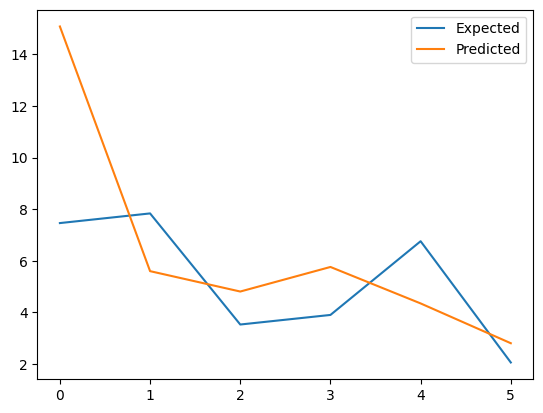

In [83]:
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Static Forecast with Random Forest')
print('MAE: %.3f' % error)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

Here the ME is less but RMSE is higher. And Direction Accuracy is lower.

## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a
recursive autoregressive (multi-step) forecaster.

In [84]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [85]:
forecaster_xgb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 4
                )

In [86]:
y_train = df_train['wPreis']
forecaster_xgb.fit(y=y_train)
predicted_test = forecaster_xgb.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [87]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [88]:
predicted_test.index = df_test.index
def adjust(val, length= 6): return str(val).ljust(length) # length
print('XGBoost Static Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))




XGBoost Static Forecast Accuracy of: wPreis
me     :  5.2218
rmse   :  5.5845
direction_accuracy :  0.6


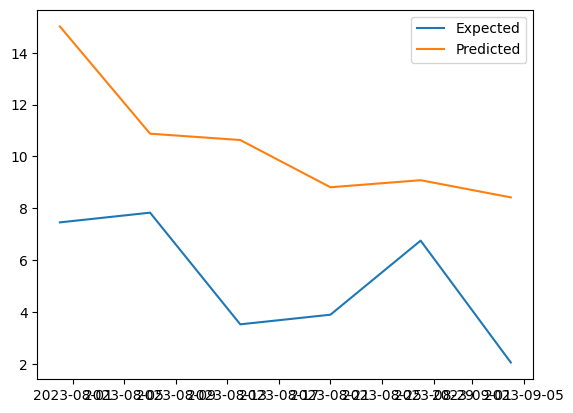

In [89]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()